In [ ]:
import numpy as np
import pyshtools as pysh
import matplotlib as plt
import boule as bl
import pandas as pd
import xarray as xr
import harmonica as hm
import verde as vd
import pygmt
from pathlib import Path

In [ ]:
PROJECT_ROOT = Path.cwd().parent
data_filename=PROJECT_ROOT/"data/boueguer_tesseroid_1deg.csv"
result_filename=PROJECT_ROOT/"data/boueguer_tesseroid_withoutmare_zhishu_1deg.csv"

In [122]:
def gmtplot(bou_xr):
    with pygmt.config(PROJ_ELLIPSOID=f"{bl.Moon2015.radius}f=0"):
        fig = pygmt.Figure()
        fig.grdimage(
            bou_xr,
            projection="R15c",
            cmap="jet",
            frame="afg",
        )
        fig.colorbar()
        fig.show()

basins = [
    ("Imbrium",     36.8,  -15.6, 650),   # ~1300 km 直径
    ("Serenitatis", 28.0,   17.5, 460),   # ~920 km
    ("Crisium",     17.0,   59.0, 530),   # ~1060 km
    ("Smythii",     -1.3,   87.5, 370),   # ~740 km
    ("Nectaris",   -15.2,   34.6, 430),   # ~860 km
    ("Humorum",    -24.4,  -38.6, 425),   # ~850 km
    ("Orientale",  -19.4,  -92.8, 465),   # ~930 km
    ("Grimaldi",    -5.5,  -68.3, 200),   # ~400 km
]

def gmtplot_basins(bou_xr, save_path=None):
    pygmt.config(PROJ_ELLIPSOID=f"{bl.Moon2015.radius}f=0")

    fig = pygmt.Figure()

    fig.grdimage(
        grid=bou_xr,
        projection="R15c",
        cmap="jet",
        frame=["afg", 'WSne'],
    )

    fig.colorbar(frame='af+l Bouguer gravity anomaly (mGal) ', position="JBC+o0c/1c")

    for name, lat, lon, radius_km in basins:
        
        fig.plot(
            x=lon,
            y=lat,
            style=f"E{2*radius_km}k",
            pen="1p,black",
        )

        fig.text(
            x=lon,
            y=lat,
            text=name,
            font="8p,Helvetica-Bold,black",
            justify="CM"
        )

    if save_path:
        fig.savefig(save_path, dpi=300)
        print(f"图已保存至: {save_path}")
    else:
        fig.show()

In [ ]:
# 读取数据
df = pd.read_csv(data_filename)
# df = pd.read_csv(r'data\moon_1deg_data.csv')

lon_raw = np.sort(df['lon'].unique())
lat_raw = np.sort(df['lat'].unique())

lon_raw = lon_raw - 180

grav_values = df.pivot(index='lat', columns='lon', values='deltaN').loc[lat_raw, df['lon'].unique()].values
topo_values = df.pivot(index='lat', columns='lon', values='topo').loc[lat_raw, df['lon'].unique()].values

nlon = grav_values.shape[1]
half = nlon // 2
grav_swapped = np.hstack([
    grav_values[:, half:],
    grav_values[:, :half]
])

lon_grid, lat_grid = np.meshgrid(lon_raw, lat_raw)

grav_da = xr.DataArray(
    grav_swapped,
    dims=("lat", "lon"),
    coords={
        "lat": lat_raw,
        "lon": lon_raw
    },
    name="bouguer_anomaly",
    attrs={"units": "mGal", "long_name": "Bouguer gravity anomaly"}
)

topo_da = xr.DataArray(
    topo_values,
    dims=("lat", "lon"),
    coords={
        "lat": lat_raw,
        "lon": lon_raw
    },
    name="topography",
    attrs={"units": "m", "long_name": "Topography height"}
)

ds = xr.Dataset(
    {
        "bouguer_anomaly": grav_da,
        "topography": topo_da
    }
)

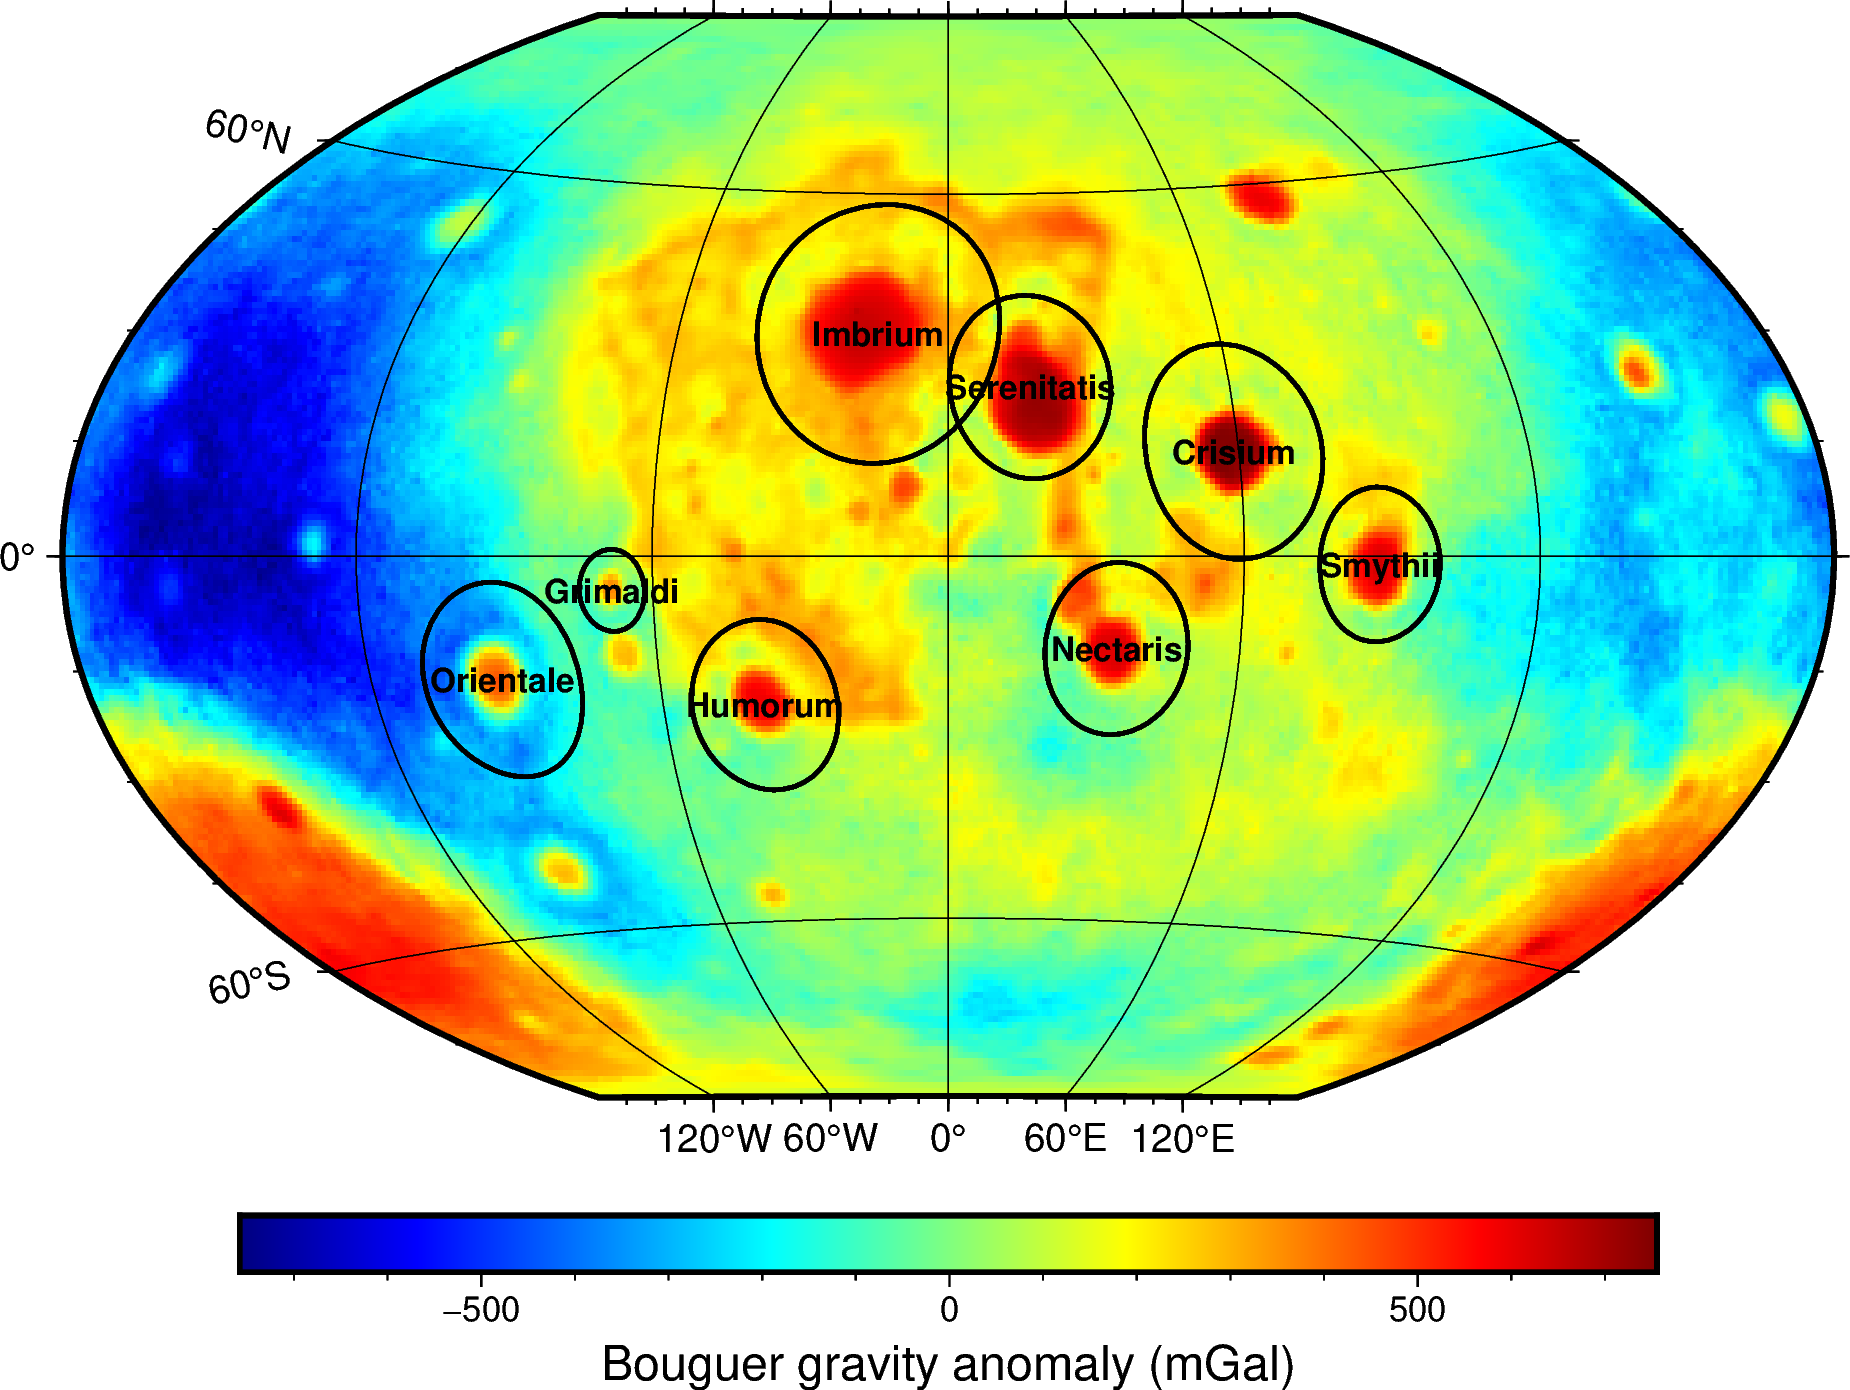

In [123]:
gmtplot_basins(grav_da)

月海深度 $\log_{10}(d)=0.41\times [\log_{10}(D)]^{0.57}$

In [19]:
import math

def calculate_depth(D):
    log_D = math.log10(D)
    exponent_part = log_D ** 0.57  # 先算 (log10(D))^0.57
    log_d = 0.41 * exponent_part   # 再乘以 0.41
    d = 10 ** log_d
    return d

basins_with_depth = []

for name, lat, lon, radius_km in basins:
    diameter_km = 2 * radius_km
    depth_km = calculate_depth(diameter_km)
    basins_with_depth.append((name, lat, lon, radius_km, diameter_km, depth_km))
    
    print(f"{name:12s}: D = {diameter_km:5.0f} km,  估算深度 d = {depth_km:.1f} km")

Imbrium     : D =  1300 km,  估算深度 d = 6.1 km
Serenitatis : D =   920 km,  估算深度 d = 5.8 km
Crisium     : D =  1060 km,  估算深度 d = 5.9 km
Smythii     : D =   740 km,  估算深度 d = 5.6 km
Nectaris    : D =   860 km,  估算深度 d = 5.7 km
Humorum     : D =   850 km,  估算深度 d = 5.7 km
Orientale   : D =   930 km,  估算深度 d = 5.8 km
Grimaldi    : D =   400 km,  估算深度 d = 5.1 km


月海建模

In [44]:
def calculate_depth(D):
    """根据你提供的经验公式计算盆地最大深度 (km)"""
    log_D = math.log10(D)
    exponent_part = log_D ** 0.57
    log_d = 0.41 * exponent_part
    d = 10 ** log_d
    return d

basin_list = []
for name, lat_c, lon_c, radius_km in basins:
    diameter_km = 2 * radius_km
    depth_max = calculate_depth(diameter_km)
    basin_list.append((name, lat_c, lon_c, radius_km, depth_max))
    print(f"{name:12s}: 直径 {diameter_km:5.0f} km → 估算最大深度 {depth_max:.1f} km")
    
Lon, Lat = np.meshgrid(lon_raw, lat_raw)

Lon_rad = np.deg2rad(Lon)
Lat_rad = np.deg2rad(Lat)

Imbrium     : 直径  1300 km → 估算最大深度 6.1 km
Serenitatis : 直径   920 km → 估算最大深度 5.8 km
Crisium     : 直径  1060 km → 估算最大深度 5.9 km
Smythii     : 直径   740 km → 估算最大深度 5.6 km
Nectaris    : 直径   860 km → 估算最大深度 5.7 km
Humorum     : 直径   850 km → 估算最大深度 5.7 km
Orientale   : 直径   930 km → 估算最大深度 5.8 km
Grimaldi    : 直径   400 km → 估算最大深度 5.1 km


In [ ]:
# 初始化
depth_sum = np.zeros_like(Lon, dtype=float)
count = np.zeros_like(Lon, dtype=int)

R_moon = bl.Moon2015.mean_radius * 1e-3  # km

# 角度统一转弧度（提前做一次）
Lat_rad = np.deg2rad(Lat)
Lon_rad = np.deg2rad(Lon)

# =========================
# 循环所有盆地
# =========================
for basin in basin_list:
    name, lat_c, lon_c, radius_km, depth_max = basin

    lat_c_rad = np.deg2rad(lat_c)
    lon_c_rad = np.deg2rad(lon_c)

    delta_lat = Lat_rad - lat_c_rad
    delta_lon = Lon_rad - lon_c_rad

    a = (
        np.sin(delta_lat / 2)**2
        + np.cos(Lat_rad) * np.cos(lat_c_rad)
        * np.sin(delta_lon / 2)**2
    )

    # 数值安全
    a = np.clip(a, 0.0, 1.0)

    delta_sigma = 2 * np.atan2(np.sqrt(a), np.sqrt(1 - a))
    d = R_moon * delta_sigma  # km

    mask = d <= radius_km

    depth_local = np.zeros_like(Lon, dtype=float)
    depth_local = -depth_max * np.exp(-(d / radius_km)**2)
    #depth_local[mask] = -depth_max * (1 - (d[mask] / radius_km)**2)

    # 累加
    depth_sum[mask] += depth_local[mask]
    count[mask] += 1


# =========================
# 取平均
# =========================
basin_depth = np.zeros_like(Lon, dtype=float)
valid = count > 0
basin_depth[valid] = depth_sum[valid] / count[valid]

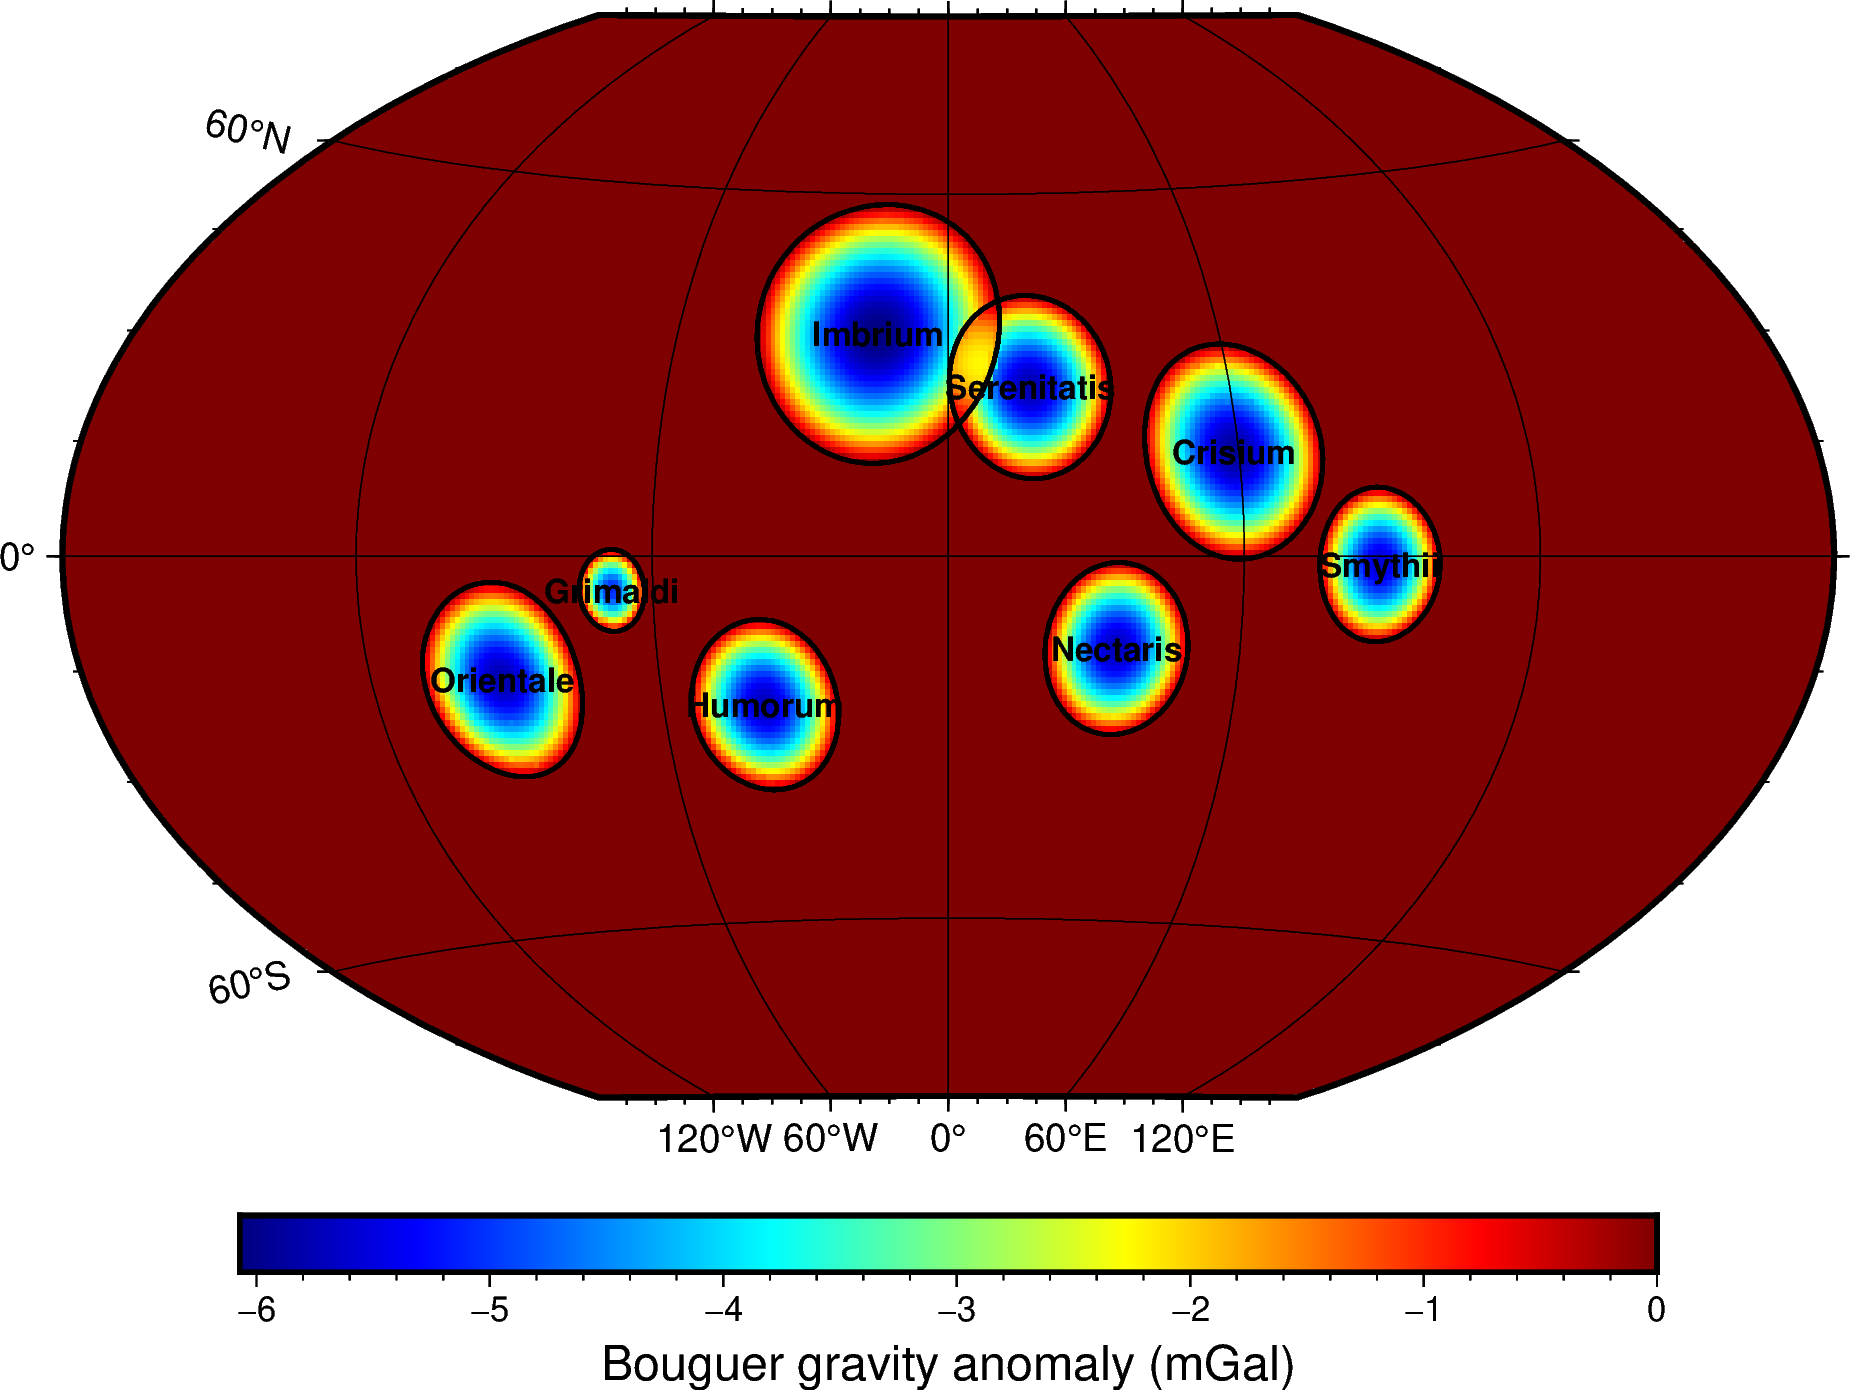

In [129]:
depth_da = xr.DataArray(
    basin_depth,
    dims=("lat", "lon"),
    coords={
        "lat": lat_raw,
        "lon": lon_raw,
    },
    name="basin_depth"
)
gmtplot_basins(depth_da)

In [131]:
surface=bl.Moon2015.mean_radius-basin_depth*1e3
reference=bl.Moon2015.mean_radius*np.ones_like(basin_depth)
density_array=(3159-2794)*np.ones_like(basin_depth)
height=11e3

In [132]:
mare_layer=hm.tesseroid_layer((lon_raw,lat_raw),surface=surface,reference=reference,properties={"density":density_array})
coordinates=(Lon,Lat,reference+height)
topo_g=mare_layer.tesseroid_layer.gravity(coordinates, field="g_z",progressbar=True)

  0%|          | 0/64800 [00:00<?, ?it/s]

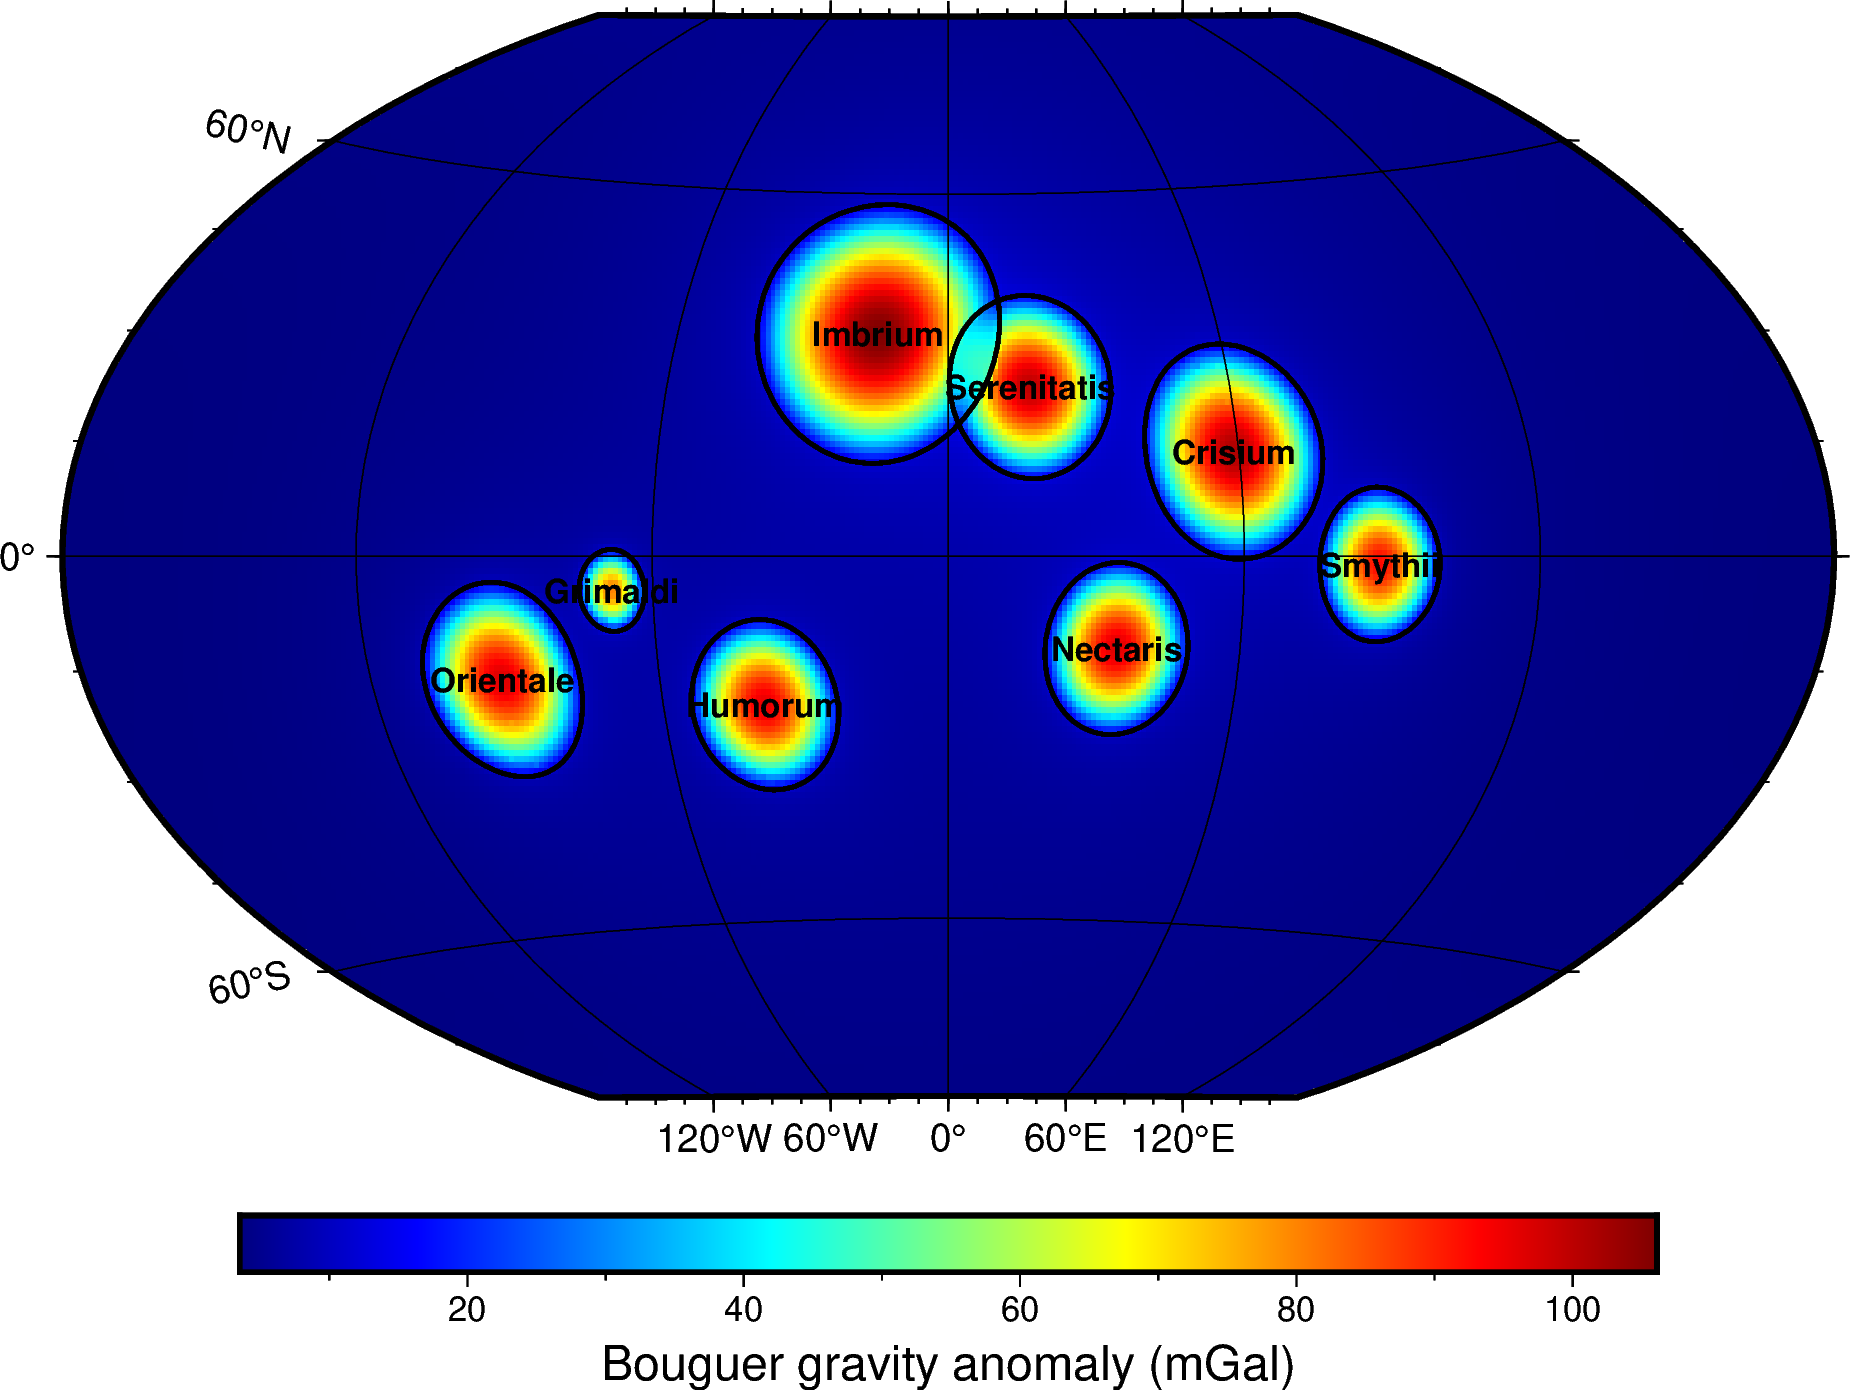

In [136]:
depth_da = xr.DataArray(
    topo_g,
    dims=("lat", "lon"),
    coords={
        "lat": lat_raw,
        "lon": lon_raw,
    },
    name="basin_depth"
)
gmtplot_basins(depth_da)

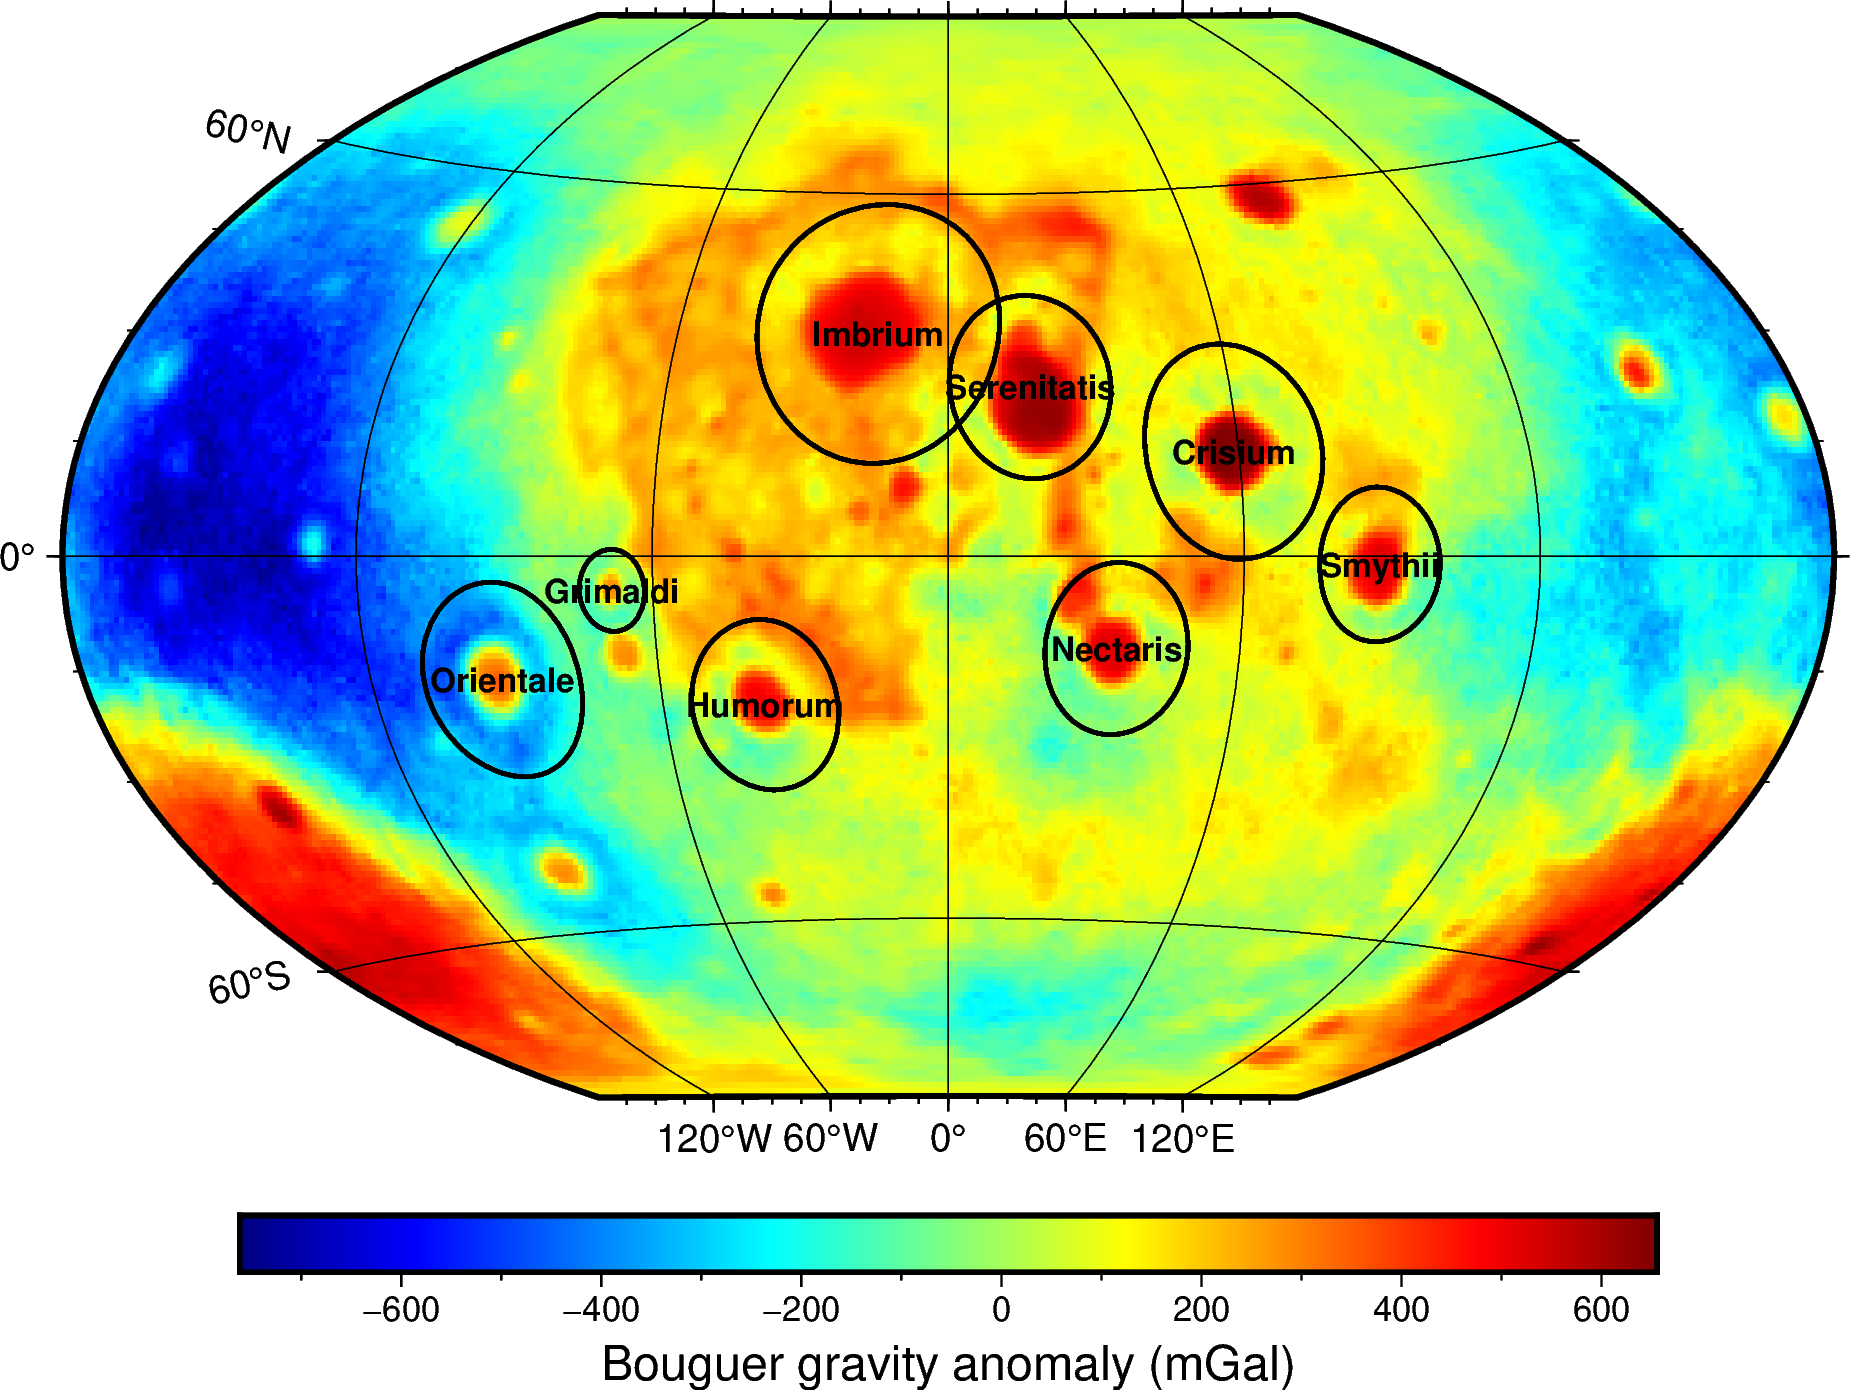

In [137]:
grav_da.data-=topo_g
gmtplot_basins(grav_da)

In [138]:
df=(
    grav_da
    .stack(points=('lat','lon'))
    .reset_index('points')
    .to_dataframe(name='deltaN')
    .reset_index(drop=True)
)
topo_da.data=topo_da.data-bl.Moon2015.mean_radius
df_topo=(
    topo_da
    .stack(points=('lat','lon'))
    .reset_index('points')
    .to_dataframe(name='topo')
    .reset_index(drop=True)
)
df=df.merge(df_topo,on=['lon', 'lat'],how='left')
df


,lat,lon,deltaN,topo
0,-89.5,-179.50000,84.863380,-3.474871e+06
1,-89.5,-178.50000,84.391625,-3.474845e+06
2,-89.5,-177.50000,83.942370,-3.474819e+06
3,-89.5,-176.50000,83.515534,-3.474792e+06
4,-89.5,-175.50000,83.110975,-3.474765e+06
...,...,...,...,...
64795,89.5,175.49999,5.540172,-3.475072e+06
64796,89.5,176.49999,5.579642,-3.475090e+06
64797,89.5,177.49999,5.615937,-3.475107e+06
64798,89.5,178.49999,5.649086,-3.475124e+06


In [ ]:
df.to_csv(
    result_filename,
    index=False,        # 不输出行号
    float_format='%.6f' # 控制浮点精度，重力数据一般够用
)